# Purpose of this notebook



In [1]:
import json
import logging
import httpx
import xarray
import pysolr
import multidict

from urllib.parse import quote

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib.pyplot as plt

from collections import Counter
from isbclient import IsbClient, MAJOR_FIELDS, FL_DEFAULT, FACET_FIELDS_DEFAULT, FACET_RANGE_FIELDS_DEFAULT, ISAMPLES_SOURCES
from isbclient import format_date_for_solr, create_date_range_query, filter_null_values
from isbclient import monkey_patch_select, SWITCH_TO_POST


from itertools import islice

logging.getLogger().setLevel(logging.INFO)

# monkeypatch pysolr?
monkey_patch_select(active=True)
SWITCH_TO_POST = 10000


# The overall iSamples API

* https://central.isample.xyz/isamples_central/docs is the swagger UI
* https://central.isample.xyz/isamples_central/openapi.json is the swagger file


In [2]:

OPENAPI_URL = 'https://central.isample.xyz/isamples_central/openapi.json'
r = httpx.get(OPENAPI_URL)
r.json()['paths'].keys()

INFO:httpx:HTTP Request: GET https://central.isample.xyz/isamples_central/openapi.json "HTTP/1.1 200 OK"


dict_keys(['/metrics', '/metrics/', '/vocabulary/material_sample_type', '/vocabulary/material_type', '/vocabulary/sampled_feature_type', '/thing', '/thing/', '/thing/types', '/thing/select/', '/thing/select', '/thing/reliquery', '/thing/stream', '/thing/select/info', '/h3_counts/', '/things', '/thing/{identifier}', '/resolve/{identifier}', '/stac_item/{identifier}', '/stac_collection/{filename}', '/things_geojson_heatmap', '/things_leaflet_heatmap', '/related', '/related/'])

# /thing/select: Solr-based select interface

In [3]:
# focus on /thing/select endpoint
r = httpx.get(OPENAPI_URL)
r.json()['paths']['/thing/select']['get']

INFO:httpx:HTTP Request: GET https://central.isample.xyz/isamples_central/openapi.json "HTTP/1.1 200 OK"


{'summary': 'Get Solr Select',
 'operationId': 'get_solr_select_thing_select_get',
 'responses': {'200': {'description': 'Successful Response',
   'content': {'application/json': {'schema': {'title': 'Response Get Solr Select Thing Select Get'}}}}}}

In [4]:
# creating a subclass of IsbClient because we're still working out the best ways to bo interact with the API

class IsbClient2(IsbClient):
    def __init__(self, url='https://central.isample.xyz/isamples_central/thing'):
        super().__init__()
        self.url = url
        self.solr = pysolr.Solr(self.url, always_commit=True)

    def _fq_from_kwargs(self, collection_date_start=1800, collection_date_end='NOW', source=None, **kwargs):
        """ 
        builds fq from a set of defaults and kwargs
        # https://github.com/django-haystack/pysolr/issues/58
        """
        # build fq
        # 'field1': quote('value with spaces and special characters like &'),

        # source is a tuple drawing from ['SESAR', 'OPENCONTEXT', 'GEOME', 'SMITHSONIAN']
        if source is not None:
            source = " or ".join([f'"{s}"' for s in source])

        filter_conditions = multidict.MultiDict({
            
            'producedBy_resultTimeRange': f'[{collection_date_start} TO {collection_date_end}]',  # Range query
            'source': source,  # Boolean logic
            '-relation_target':'*'
        })

        # update filter_conditions with kwargs
        m = kwargs.get('_multi')
        if m is None:
            m = multidict.MultiDict(kwargs)
        else:
            del kwargs['_multi']
            m.extend(kwargs)
        filter_conditions.update(m)

        # Convert to list of fq strings
        fq = [f'{field}:{value}' for field, value in filter_null_values(filter_conditions).items()]

        # fq = ['producedBy_resultTimeRange:[1800 TO 2023]', 'source:(OPENCONTEXT or SESAR)', '-relation_target:*']
        return fq

    def default_search_params(self, q='*:*',
                       fl = FL_DEFAULT,
                       fq = None,
                       start=0, rows=20, 
                       facet_field = FACET_FIELDS_DEFAULT,
                       sort =  'id ASC',
                       **kwargs):
        
        if fq is None:
            fq = self._fq_from_kwargs()
    
        params={
            'q': q, 
            'fl': fl,
            'start':start, 
            'rows': rows, 
            'fq': fq,
            'facet': 'on',
            'facet.field': facet_field,
            'cursorMark': '*',
            'sort': sort,
        }

        # update params with kwargs
        params.update(kwargs)
        return params
                
    def search(self, params=None, **kwargs):
        """ 
        params vs kwargs: 
        if params is None, then build params from kwargs
        one exception: if kwargs has thingselect, using the thing/select endpoint
        """
        if params is None:
            params = self.default_search_params(**kwargs)

        # give an option to pick how to do the search
        if kwargs.get('thingselect', False):
            return self._request("thing/select", params)
        else:
            return self.solr.search(**params)



# documentation about Solr query language

[The Standard Query Parser | Apache Solr Reference Guide 8.11](https://solr.apache.org/guide/8_11/the-standard-query-parser.html#standard-query-parser-parameters):

> Solr’s default Query Parser is also known as the “lucene” parser.   
> [....]   
> q: Defines a query using standard query syntax. This parameter is mandatory

Note [Differences between Lucene’s Classic Query Parser and Solr’s Standard Query Parser](https://solr.apache.org/guide/8_11/the-standard-query-parser.html#differences-between-lucenes-classic-query-parser-and-solrs-standard-query-parser)

there are "existence searches" [The Standard Query Parser | Apache Solr Reference Guide 8.11](https://solr.apache.org/guide/8_11/the-standard-query-parser.html#existence-searches):

> An existence search for a field matches all documents where a value exists for that field. To query for a field existing, simply use a wildcard instead of a term in the search.
>
> field:*
>
> A field will be considered to "exist" if it has any value, even values which are often considered "not existent". (e.g., NaN, "", etc.)

Good tutorial on the query syntax of Solr (apart from the official documentation): [Solr Query Syntax and Examples](https://yonik.com/solr/query-syntax/)


Translate the UI from https://central.isample.xyz/isamples_central/ui into widgetized forms to formulate query

* display number of hits
* display facets

map
dataframe


In [5]:
cli = IsbClient2()
fq = cli._fq_from_kwargs(source=('OPENCONTEXT',))
params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=100, **FACET_RANGE_FIELDS_DEFAULT)

# use the /thing/select endpoint directly
query = cli.search(params=params, thingselect=True)
# print number of hits
print (len(query))
results = islice(query, 300)

df = DataFrame(results)
df.head()

INFO:httpx:HTTP Request: GET https://central.isample.xyz/isamples_central/thing/select?q=%2A%3A%2A&fl=searchText&fl=authorizedBy&fl=producedBy_resultTimeRange&fl=hasContextCategory&fl=curation_accessContraints&fl=curation_description_text&fl=curation_label&fl=curation_location&fl=curation_responsibility&fl=description_text&fl=id&fl=informalClassification&fl=keywords&fl=label&fl=hasMaterialCategory&fl=producedBy_description_text&fl=producedBy_hasFeatureOfInterest&fl=producedBy_label&fl=producedBy_responsibility&fl=producedBy_resultTime&fl=producedBy_samplingSite_description_text&fl=producedBy_samplingSite_label&fl=producedBy_samplingSite_location_elevationInMeters&fl=producedBy_samplingSite_location_latitude&fl=producedBy_samplingSite_location_longitude&fl=producedBy_samplingSite_placeName&fl=registrant&fl=samplingPurpose&fl=source&fl=sourceUpdatedTime&fl=producedBy_samplingSite_location_rpt&fl=hasSpecimenCategory&start=0&rows=100&fq=producedBy_resultTimeRange%3A%5B1800%20TO%20NOW%5D&fq

4


,0
0,responseHeader
1,response
2,nextCursorMark
3,facet_counts


In [6]:
logging.getLogger().setLevel(logging.CRITICAL)

# monkeypatch pysolr?
monkey_patch_select(active=True)
SWITCH_TO_POST = 100000

cli = IsbClient2()
# build fq: OpenContext source and search for bone
fq = cli._fq_from_kwargs(source=('OPENCONTEXT',), searchText="bone")
params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=100, **FACET_RANGE_FIELDS_DEFAULT)

# use pysolr to get the results
query = cli.search(params=params)
# print number of hits
print (len(query))
results = islice(query, 1000)

df = DataFrame(results)
df.head(2)

501179


,id,sourceUpdatedTime,label,searchText,description_text,hasContextCategory,hasMaterialCategory,hasSpecimenCategory,keywords,registrant,...,producedBy_responsibility,producedBy_resultTime,producedBy_resultTimeRange,producedBy_samplingSite_description_text,producedBy_samplingSite_label,producedBy_samplingSite_placeName,producedBy_samplingSite_location_rpt,producedBy_samplingSite_location_latitude,producedBy_samplingSite_location_longitude,source
0,ark:/28722/k2000027w,2023-10-04T06:00:39Z,Animal Bone Bone Ref# 3008,"[Animal Bone Bone Ref# 3008, 'early bce/ce': -...",'early bce/ce': -6700.0 | 'late bce/ce': -6000...,[Site of past human activities],[biogenicnonorganicmaterial],"[ornament, container, architectural element]","[Agriculture, Animal remains (Archaeology), Ar...",[],...,[creator:Denise Carruthers],2013-03-04T00:00:00Z,2013-03-04T00:00:00Z,https://opencontext.org/subjects/2767a2d2-a050...,Pınarbaşı,"[Asia, Turkey, Pınarbaşı, Site B, Context BCF]",POINT (33.018551 37.49432),37.49432,33.01855,OPENCONTEXT
1,ark:/28722/k2000028c,2023-10-04T05:58:40Z,Animal Bone Bone Ref# 2237,"[Animal Bone Bone Ref# 2237, 'early bce/ce': -...",'early bce/ce': -6700.0 | 'late bce/ce': -6000...,[Site of past human activities],[biogenicnonorganicmaterial],"[container, ornament, architectural element]","[Agriculture, Animal remains (Archaeology), Ar...",[],...,[creator:Denise Carruthers],2013-03-04T00:00:00Z,2013-03-04T00:00:00Z,https://opencontext.org/subjects/2767a2d2-a050...,Pınarbaşı,"[Asia, Turkey, Pınarbaşı, Site B, Context BBJ]",POINT (33.018551 37.49432),37.49432,33.01855,OPENCONTEXT


In [8]:
# let's look at the data coming back and see how to make sense of them.
# expect the columns in the DataFrame to be a proper subset of FL_DEFAULT


def set_diff(a, b):
    return set(a) - set(b), set(b) - set(a)


assert set(df.columns) - set(FL_DEFAULT) == set()


len(df)

1000

In [9]:
# can I get type information from the API?
# it doesn't seem like /thing/select will return type information

# save a copy of df to df0
df0 = df.copy()

# df.infer_objects().dtypes
df = df.convert_dtypes()

# some of the columns are datetimes
for k in ['sourceUpdatedTime', 'producedBy_resultTime', 'producedBy_resultTimeRange']:
    df[k] = pd.to_datetime(df[k], errors='coerce').dt.tz_localize(None)

# spit out to Excel to look at the data in spreadsheet form
df.to_excel('bone.xlsx')


In [10]:
df['sourceUpdatedTime'].describe()

count                             1000
mean     2023-10-05 08:03:53.059000064
min                2023-10-03 21:16:17
25%                2023-10-04 09:02:13
50%         2023-10-04 13:27:03.500000
75%                2023-10-06 17:49:52
max                2023-10-08 06:43:43
Name: sourceUpdatedTime, dtype: object

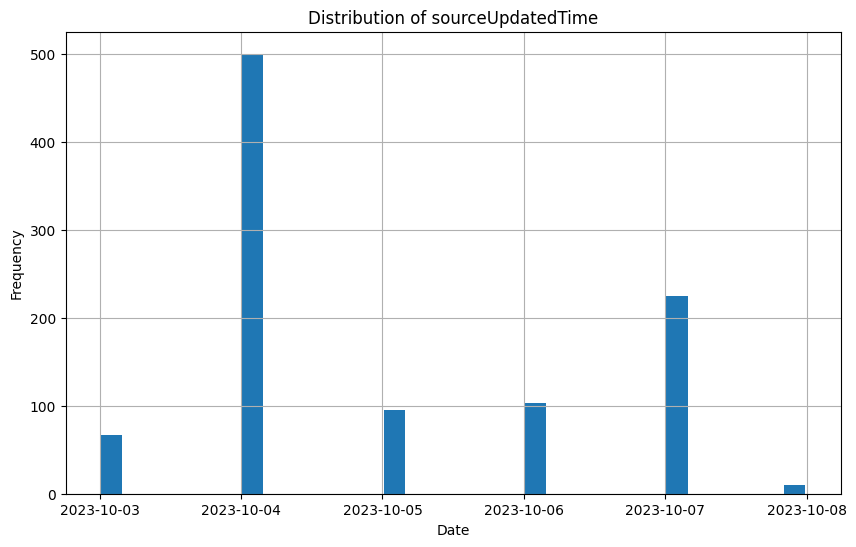

In [11]:
import matplotlib.pyplot as plt

# Convert the datetime64 column to just date
df['sourceUpdatedTime'] = df['sourceUpdatedTime'].dt.date

# Plot a histogram
plt.figure(figsize=(10,6))
df['sourceUpdatedTime'].hist(rwidth=0.9, bins=30)
plt.title('Distribution of sourceUpdatedTime')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

In [12]:
import ipydatagrid as ipg
ipg.__version__

'1.2.1'

In [16]:
# load the df into ipydatagrid
from ipydatagrid import DataGrid

dg = DataGrid(df, editable=True)
dg

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [18]:
# what type of events are supported by ipydatagrid
# selection events, what rows are shown? what columns?

dg.selected_cells

[{'r': 6, 'c': 2},
 {'r': 6, 'c': 3},
 {'r': 7, 'c': 2},
 {'r': 7, 'c': 3},
 {'r': 8, 'c': 2},
 {'r': 8, 'c': 3}]

In [14]:
# use Jupyter widgets to allow for change in searchText and display the number of results in a output widget

import ipywidgets as widgets
from IPython.display import display

logging.getLogger().setLevel(logging.CRITICAL)

# monkeypatch pysolr?
monkey_patch_select(active=True)
SWITCH_TO_POST = 100000

cli = IsbClient2()

# build fq: OpenContext source and search for bone
fq = cli._fq_from_kwargs(searchText="bone")
params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=10, **FACET_RANGE_FIELDS_DEFAULT)
query = cli.search(params=params)
num_hits = len(query)

# Create a text input widget
search_text = widgets.Text(
    value='',
    placeholder='Type something',
    description='Search:',
)
# Create an output widget
output = widgets.Output()

# Define a function to handle changes to the text input
def on_text_change(change):
    output.clear_output()  # Clear the previous results
    fq = cli._fq_from_kwargs(searchText=change['new'])
    params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=10, **FACET_RANGE_FIELDS_DEFAULT)
    query = cli.search(params=params)
    num_hits = len(query)

    with output:
        print(f"Number of hits: {num_hits}")  # Display the new search text

# Attach the event handler to the text input
search_text.observe(on_text_change, names='value')

# Display the widgets
display(search_text)
display(output)

Text(value='', description='Search:', placeholder='Type something')

Output()

In [ ]:
params

In [ ]:
# write out the call to iSamples using httpx to compare get vs post

import httpx
ISB_SERVER = "https://central.isample.xyz/isamples_central/"

r = httpx.request('GET', f'{ISB_SERVER}/thing/select', params=params)
r.json()['response']['numFound']

In [ ]:
# make a post request version

from urllib.parse import urlencode

headers = {
    "Content-type": "application/x-www-form-urlencoded; charset=utf-8"
}

params_encoded = urlencode(params)
r = httpx.post(f'{ISB_SERVER}/thing/select', data=params_encoded, headers=headers)
r

In [ ]:
r.json()

In [ ]:
assert set(query.raw_response.keys()) == set(['responseHeader', 'response', 'nextCursorMark', 'facet_counts'])

In [ ]:
# dict_keys(['facet_queries', 'facet_fields', 'facet_ranges', 'facet_intervals', 'facet_heatmaps'])
query.raw_response['facet_counts'].keys()

query.raw_response['facet_counts']['facet_fields'].keys()

In [ ]:
query.raw_response['facet_counts']['facet_fields']['source']

In [ ]:
from ipytree import Tree, Node
from ipyleaflet import Map, Marker
from ipywidgets import HBox, link, Layout

m = Map(center=[47.51, 4.04], zoom=4, layout=Layout(height='400px'))
tree = Tree()
tree.layout.width = '40%'
box = HBox([tree, m])

markers_node = Node('Markers')
tree.add_node(markers_node)

layers_node = Node('Layers', icon='map')
tree.add_node(layers_node)

cities = [
    {'name': 'London', 'location': [51.5074, 0.1278]},
    {'name': 'Paris', 'location': [48.8566, 2.3522]},
    {'name': 'Barcelona', 'location': [41.31, 2.109]}
]

for city in cities:
    marker = Marker(location=city.get('location'))
    node = Node(city.get('name'), icon='map-marker')

    link((marker, 'visible'), (node, 'selected'))

    m.add_layer(marker)
    markers_node.add_node(node)

box

In [ ]:
# query.raw_response.keys() --> dict_keys(['responseHeader', 'response', 'nextCursorMark', 'facet_counts'])
query.raw_response['facet_counts']['facet_ranges'].keys()

In [ ]:
# keys: dict_keys(['facet_queries', 'facet_fields', 'facet_ranges', 'facet_intervals', 'facet_heatmaps'])
query.raw_response['facet_counts']['facet_ranges'].keys()

In [ ]:
# 'responseHeader', 'index', 'schema', 'info'
r = cli._request("thing/select/info")
r.keys()

In [ ]:
r['schema']['fields'].keys()

In [ ]:
# timeout internal server error
if False:
    r = cli._request("thing/types")

In [ ]:
# types and classnames for all the fields on the system
Counter([(x['type'], r['schema']['types'][x['type']]['className']) for x in r['schema']['fields'].values()])

In [ ]:
# e.g, I for Indexed, T for Tokenized, S for Stored, etc.
r['info']['key']

# ['fields', 'dynamicFields', 'uniqueKeyField', 'similarity', 'types']
r['schema'].keys()

# get the fields -- 78 of them
print ("number of fields", len(r['schema']['fields'].keys()))

field_names = cli.field_names()
print("number of field names (another way to access)", len(field_names))

print ("types for the major fields")
[(k,v['type'], r['schema']['types'][v['type']]['className'] ) for (k,v) in r['schema']['fields'].items() if k in MAJOR_FIELDS.values()]

In [ ]:
from urllib.parse import urlparse, parse_qs

url = 'https://central.isample.xyz/isamples_central/thing/select?q=*:*&fl=searchText%20authorizedBy%20producedBy_resultTimeRange%20hasContextCategory%20curation_accessContraints%20curation_description_text%20curation_label%20curation_location%20curation_responsibility%20description_text%20id%20informalClassification%20keywords%20label%20hasMaterialCategory%20producedBy_description_text%20producedBy_hasFeatureOfInterest%20producedBy_label%20producedBy_responsibility%20producedBy_resultTime%20producedBy_samplingSite_description_text%20producedBy_samplingSite_label%20producedBy_samplingSite_location_elevationInMeters%20producedBy_samplingSite_location_latitude%20producedBy_samplingSite_location_longitude%20producedBy_samplingSite_placeName%20registrant%20samplingPurpose%20source%20sourceUpdatedTime%20producedBy_samplingSite_location_rpt%20hasSpecimenCategory&fq=producedBy_resultTimeRange%3A%5B1800%20TO%202023%5D&fq=source%3A(%22OPENCONTEXT%22%20OR%20%22SESAR%22)&fq=-relation_target%3A*&facet.field=authorizedBy&facet.field=hasContextCategory&facet.field=hasMaterialCategory&facet.field=registrant&facet.field=source&facet.field=hasSpecimenCategory&facet.range=producedBy_resultTimeRange&facet.range.gap=%2B1YEARS&facet.range.start=1800-01-01T00:00:00Z&facet.range.end=2023-01-01T00:00:00Z&f.registrant.facet.sort=count&f.source.facet.sort=index&rows=20&facet.limit=-1&facet.sort=index&&start=0&facet=on&wt=json'

parsed_url = urlparse(url)
query_params = parse_qs(parsed_url.query)

# The result is a dictionary where each key is associated with a list of values.
# You can iterate over this dictionary to process your parameters as needed.
for key, values in query_params.items():
    print(f"{key}: {values}")

# If you need each key to have a single value (taking the first value if multiple are present),
# you can do the following:
single_value_params = {key: values[0] for key, values in query_params.items()}
print(single_value_params)


In [ ]:
# simplest query -- default

cli._request("thing/select", params={'q': '*:*', 'start':0, 'rows': 10, 
        'fq': ['producedBy_resultTimeRange:[1800 TO 2023]', 'source:(OPENCONTEXT or SESAR)', '-relation_target:*'],
        'facet.field': ['authorizedBy', 'hasContextCategory', 'hasMaterialCategory', 'registrant', 'source', 'hasSpecimenCategory'],
        'facet': 'on',
        })

I *think* I had ChatGPT parse the parameters and give me the following interpretation:

Let's break down these parameters, which are used for querying a Solr search engine. Solr is an open-source search platform that provides a wide range of capabilities for text search and faceted search, among other features.

q: This parameter specifies the query. Here, *:* is a wildcard query, meaning it matches all documents in the Solr index.


[fl](https://solr.apache.org/guide/8_11/common-query-parameters.html#fl-field-list-parameter): This stands for "field list". It specifies the fields to return in the result. In your query, a long list of fields like searchText, authorizedBy, producedBy_resultTimeRange, etc., are included. Only these fields will be returned for each document in the search results.

fq: This is the "filter query". It filters the results returned by the main query (q) without influencing the score. Here, there are three filters applied:

> producedBy_resultTimeRange:[1800 TO 2023] filters documents to those produced between the years 1800 and 2023.
source:(OPENCONTEXT) filters documents where the source field matches "OPENCONTEXT".
-relation_target:* excludes documents where the relation_target field exists.
facet.field: Faceting is used to aggregate data based on a field. This parameter specifies the fields for which you want to see facet counts. Facets on fields like authorizedBy, hasContextCategory, etc., are requested.


facet.range, facet.range.gap, facet.range.start, and facet.range.end: These parameters are used for range faceting. You are faceting on the producedBy_resultTimeRange field, starting from "1800-01-01T00:00:00Z" to "2023-01-01T00:00:00Z", with a gap of "+1YEARS". This means it will provide counts for each year in this range.

f.registrant.facet.sort and f.source.facet.sort: These are sorting instructions for the facets. The registrant facet is sorted by count, and the source facet is sorted by index.

rows: This specifies the number of documents to return. In your query, it's set to 20.

facet.limit: This limits the number of facet values returned for each facet field. -1 means no limit.

facet.sort: It dictates how to sort the facet fields. Here, it's sorted by index.

start: This is the offset in the complete result set for pagination. It tells Solr where to start in the list of results (useful for paging through results).

facet: When set to 'on', it enables faceting.

wt: This stands for "writer type" and specifies the output format. Here, 'json' indicates that the response should be in JSON format.

In [ ]:
import httpx


url = "https://central.isample.xyz/isamples_central/thing/select"
params = {
    'q': '*:*',
    'fl': 'searchText authorizedBy producedBy_resultTimeRange hasContextCategory curation_accessContraints curation_description_text curation_label curation_location curation_responsibility description_text id informalClassification keywords label hasMaterialCategory producedBy_description_text producedBy_hasFeatureOfInterest producedBy_label producedBy_responsibility producedBy_resultTime producedBy_samplingSite_description_text producedBy_samplingSite_label producedBy_samplingSite_location_elevationInMeters producedBy_samplingSite_location_latitude producedBy_samplingSite_location_longitude producedBy_samplingSite_placeName registrant samplingPurpose source sourceUpdatedTime producedBy_samplingSite_location_rpt hasSpecimenCategory',
    'fq': ['producedBy_resultTimeRange:[1800 TO 2023]', 'source:(OPENCONTEXT)', '-relation_target:*'],
    'facet.field': ['authorizedBy', 'hasContextCategory', 'hasMaterialCategory', 'registrant', 'source', 'hasSpecimenCategory'],
    'facet.range': 'producedBy_resultTimeRange',
    'facet.range.gap': '+1YEARS',
    'facet.range.start': '1800-01-01T00:00:00Z',
    'facet.range.end': '2023-01-01T00:00:00Z',
    'f.registrant.facet.sort': 'count',
    'f.source.facet.sort': 'index',
    'rows': '20',
    'facet.limit': '-1',
    'facet.sort': 'index',
    'start': '20',
    'facet': 'on',
    'wt': 'json'
}
headers = {
    'Accept': 'application/json',
    'User-Agent': 'raymondyee.net'
}

# keys in response: 'responseHeader', 'response', 'facet_counts'
response = httpx.get(url, params=params, headers=headers)


In [ ]:
# get back parameters that went into the query and some basic metadata
response.json()['responseHeader']

In [ ]:
# 'numFound', 'start', 'numFoundExact', 'docs'
response.json()['response'].keys()

(response.json()['response']['numFound'], response.json()['response']['numFoundExact'])


In [ ]:
response.json()['response']['docs'][0].keys()

# plotting the collection dates

In [ ]:
import httpx

cli = IsbClient2()
fq = cli._fq_from_kwargs(source=('OPENCONTEXT',))
params = cli.default_search_params(fq=fq, fl=FL_DEFAULT, rows=100, **FACET_RANGE_FIELDS_DEFAULT)


url = 'https://central.isample.xyz/isamples_central/thing/select/info'
url = 'https://central.isample.xyz/isamples_central/thing/select?q=*:*&facet=true&facet.range=producedBy_resultTimeRange&facet.range.start=NOW/YEAR-200YEARS&facet.range.end=NOW/YEAR&facet.range.gap=YEAR'


headers = {
    'accept': 'application/json'
}

response = httpx.get('https://central.isample.xyz/isamples_central/thing/select', headers=headers, params=params)

print(response.json())


In [ ]:
response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']

In [ ]:

k = response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']
dict(zip(k[::2], k[1::2]))



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data is your response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']
k = response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']
data = dict(zip(k[::2], k[1::2]))


# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(data.items()), columns=['Date', 'Count'])

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year from the date
df['Year'] = df['Date'].dt.year

# Count the occurrences of each year
year_counts = df['Year'].value_counts().sort_index()

# Plot the counts vs year
year_counts.plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count vs Year')
plt.show()


In [ ]:
k = response.json()['facet_counts']['facet_ranges']['producedBy_resultTimeRange']['counts']
data = dict(zip(k[::2], k[1::2]))

df = pd.DataFrame(list(data.items()), columns=['Date', 'Count'])
df.plot()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame
df['Date'] = pd.to_datetime(df['Date'])

# deal with log scale
df = df.loc[df['Count'] != 0]

# df['Count'] = df['Count'].replace(0, np.nan)
# df['Count'] = df['Count'].fillna(0.1)

plt.figure(figsize=(10,6))
plt.scatter(df['Date'], df['Count'], color='green', alpha=0.5, s=10)
plt.yscale('log')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Date')
plt.show()

In [ ]:
%%bash

curl -X 'GET' \
  'https://central.isample.xyz/isamples_central/thing/select?facet=true&facet.mincount=0&facet.field=source' \
  -H 'accept: application/json'

In [ ]:
field_names = cli.field_names()


In [ ]:
len(field_names)

In [ ]:
fields = ["source", "hasMaterialCategory", "hasContextCategory"]
facets = cli.facets("*:*", fields)
print(json.dumps(facets, indent=2))

In [ ]:
# Get counts of values grouping by three dimsions: source, hasMaterialCategory, and hasContextCategory
dimensions = ["source", "hasMaterialCategory", "hasContextCategory"]
xd = cli.pivot("*:*", dimensions)
print(xd.loc["geome", "organic material", "bacteria"].sum())

In [ ]:
# Get counts of values grouping by three dimsions: source, hasMaterialCategory, and hasContextCategory
dimensions = ["source", "hasMaterialCategory", "hasContextCategory"]
xd = cli.pivot("*:*", dimensions)
print(xd.loc["geome", "organic material", "bacteria"].sum())

In [ ]:
# Sum by axis 2 (hasContextCategory) and print
df = xd.sum(axis=2).to_pandas()
# display transposed
display(df.T)


In [ ]:
print(xd.loc["sesar", "rock"].sum())

In [ ]:
# Field names in solr
for name in cli.field_names():
    print(name)